In [63]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm_notebook
from datetime import datetime
from sklearn.model_selection import KFold

In [2]:
pd.options.display.max_columns = None

In [3]:
PATH = os.path.join('..', 'input')

In [4]:
os.listdir(PATH)

['.DS_Store',
 'Data_Dictionary.xlsx',
 'new_merchant_transactions.csv',
 'test.csv',
 '~$Data_Dictionary.xlsx',
 'merchants.csv',
 'historical_transactions.csv',
 'train.csv',
 'sample_submission.csv']

# Train Data

In [30]:
train_df = pd.read_csv(os.path.join(PATH, 'train.csv'), parse_dates=['first_active_month'])

In [31]:
train_df['year'] = train_df['first_active_month'].dt.year
train_df['month'] = train_df['first_active_month'].dt.month
train_df['day'] = train_df['first_active_month'].dt.month

In [32]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,day
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,6
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,1
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,8
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017,9,9
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11,11


# Test Data

In [33]:
test_df = pd.read_csv(os.path.join(PATH, 'test.csv'), parse_dates=['first_active_month'])

In [34]:
test_df['year'] = test_df['first_active_month'].dt.year
test_df['month'] = test_df['first_active_month'].dt.month
test_df['day'] = test_df['first_active_month'].dt.month

In [35]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month,day
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,2017.0,4.0,4.0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,2017.0,1.0,1.0
2,2017-08-01,C_ID_b709037bc5,5,1,1,2017.0,8.0,8.0
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2017.0,12.0,12.0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,2015.0,12.0,12.0


# Historical Transactions

In [14]:
hist_df = pd.read_csv(os.path.join(PATH, 'historical_transactions.csv'))

In [64]:
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [28]:
grouped = hist_df.groupby('card_id')['purchase_amount'].agg(
    ['sum', 'mean', 'std', 'max', 'min', 'size']).reset_index()
grouped.columns = ["card_id", "sum_hist", "mean_hist",
                   "std_hist", "max_hist", "min_hist", 'size_hist']

In [29]:
grouped.head()

,card_id,sum_hist,mean_hist,std_hist,max_hist,min_hist,size_hist
0,C_ID_00007093c1,-76.845041,-0.515739,0.298141,1.507069,-0.728876,149
1,C_ID_0001238066,-72.447201,-0.589002,0.190235,0.768095,-0.734887,123
2,C_ID_0001506ef0,-34.601879,-0.524271,0.472284,1.493545,-0.740491,66
3,C_ID_0001793786,-36.786013,-0.170306,0.836046,4.554145,-0.745405,216
4,C_ID_000183fdda,-68.837938,-0.478041,0.524948,2.764788,-0.737892,144


In [36]:
# merge train_df and test_df
train_df = pd.merge(train_df, grouped, on='card_id', how='left')
test_df = pd.merge(test_df, grouped, on='card_id', how='left')

# New Merchant Transactions

In [37]:
new_trans_df = pd.read_csv(os.path.join(PATH, 'new_merchant_transactions.csv'))

In [39]:
grouped = new_trans_df.groupby('card_id')['purchase_amount'].agg(
    ['sum', 'mean', 'std', 'max', 'min']).reset_index()
grouped.columns = ["card_id", "sum_merch",
                   "mean_merch", "std_merch", "min_merch", "max_merch"]

In [40]:
# merge train_df and test_df
train_df = pd.merge(train_df, grouped, on='card_id', how='left')
test_df = pd.merge(test_df, grouped, on='card_id', how='left')

# Baseline

In [41]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,day,sum_hist,mean_hist,std_hist,max_hist,min_hist,size_hist,sum_merch,mean_merch,std_merch,min_merch,max_merch
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,6,-165.968739,-0.638341,0.212139,2.258395,-0.739395,260,-13.244202,-0.575835,0.135812,-0.296112,-0.724368
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,1,-210.006336,-0.600018,0.384967,4.630299,-0.742400,350,-4.355735,-0.725956,0.014326,-0.701858,-0.739410
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,8,-29.167391,-0.678311,0.087380,-0.145847,-0.730138,43,-0.700326,-0.700326,NaN,-0.700326,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017,9,9,-49.491364,-0.642745,0.261624,1.445596,-0.740897,77,-4.654372,-0.664910,0.065882,-0.566740,-0.734135
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11,11,-48.687656,-0.366073,1.352094,7.193041,-0.746156,133,-19.926237,-0.553507,0.223821,0.450886,-0.739395


In [45]:
not_features = ['first_active_month', 'card_id', 'target']
features = [feature for feature in train_df.columns if feature not in not_features]

In [56]:
def kfold_LightGBM(train_df, test_df, target, features):
    train_y = train_df[target]
    train_df = train_df[features]
    test_df = test_df[features]

    kfolds = KFold(n_splits=5, random_state=618, shuffle=True)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 30,
        "min_child_weight": 50,
        "learning_rate": 0.05,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.7,
        "bagging_frequency": 5,
        "bagging_seed": 2018,
        "verbosity": -1
    }
    
    preds = np.zeros(test_df.shape[0])

    for train_idx, valid_idx in kfolds.split(train_df):
        dtrain = lgb.Dataset(
            train_df.loc[train_idx, :], label=train_y[train_idx])
        dvalid = lgb.Dataset(
            train_df.loc[valid_idx, :], label=train_y[valid_idx])

        evals_result = {}
        model = lgb.train(params, dtrain, 1000, 
                          valid_sets=[dtrain, dvalid], 
                          early_stopping_rounds=100, 
                          verbose_eval=100, 
                          evals_result=evals_result)
        
        preds += model.predict(test_df, num_iterations=model.best_iteration) / kfolds.n_splits
    
    return preds, model

In [57]:
preds, model = kfold_LightGBM(train_df, test_df, 'target', features)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.77248	valid_1's rmse: 3.75724
[200]	training's rmse: 3.73939	valid_1's rmse: 3.75707
Early stopping, best iteration is:
[128]	training's rmse: 3.76226	valid_1's rmse: 3.75644
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.7746	valid_1's rmse: 3.75588
[200]	training's rmse: 3.74201	valid_1's rmse: 3.75445
[300]	training's rmse: 3.71565	valid_1's rmse: 3.75529
Early stopping, best iteration is:
[202]	training's rmse: 3.74143	valid_1's rmse: 3.75438
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.75848	valid_1's rmse: 3.81845
[200]	training's rmse: 3.72588	valid_1's rmse: 3.81828
Early stopping, best iteration is:
[118]	training's rmse: 3.75157	valid_1's rmse: 3.81817
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.73257	valid_1's rmse: 3.9168
[200]	training's rmse: 3.69795	valid_1's

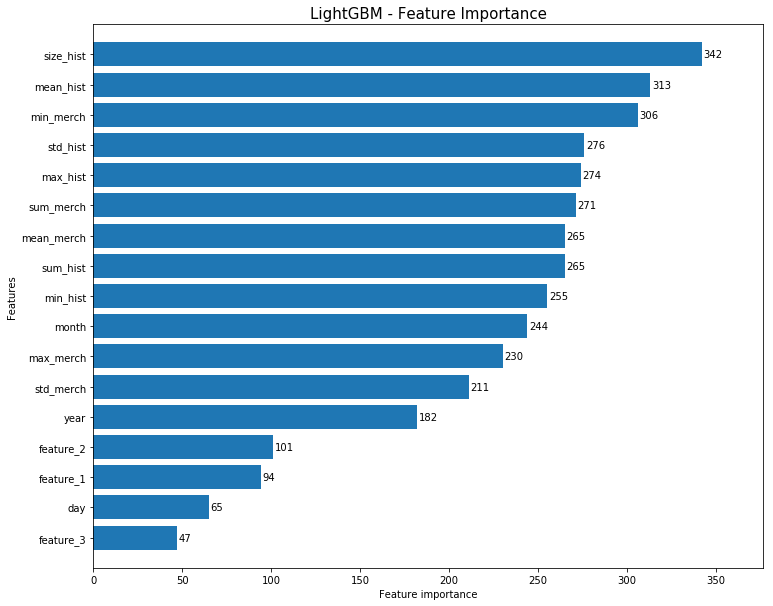

In [59]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [62]:
sub_df = pd.DataFrame({"card_id": test_df["card_id"].values})
sub_df["target"] = preds
sub_df.to_csv(os.path.join('..', 'submission', "baseline_lgb_1207.csv"), index=False)